In [2]:
import pandas as pd
import os

# Load the dataset
df = pd.read_csv("C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\text_5_descr_celeba.csv")

# Inspect the dataset
print("Dataset Columns:", df.columns)
print(df.head())

# Extract 'smiling' label for binary classification
df['smiling'] = df['text_description'].str.contains('smiling', case=False, na=False).astype(int)

# Create 'image_path' by combining directory path with image names
image_dir = r"C:\Users\SWAGA\Downloads\Lab5_NNDL\Images"
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, x))

# Verify image paths
print("Valid image paths:", df['image_path'].apply(os.path.exists).sum())
print("Invalid image paths:", (~df['image_path'].apply(os.path.exists)).sum())


Dataset Columns: Index(['image_id', 'text_description'], dtype='object')
     image_id                                   text_description
0  000001.jpg  The lady has pretty high cheekbones. Her hair ...
1  000002.jpg  The lady has pretty high cheekbones. She has b...
2  000003.jpg  His hair is wavy. He has big lips, narrow eyes...
3  000004.jpg  Her hair is straight. She has a pointy nose. T...
4  000005.jpg  She has arched eyebrows, big lips, narrow eyes...
Valid image paths: 1526
Invalid image paths: 48474


In [3]:
# Extract 'smiling' label from descriptions
df['smiling'] = df['text_description'].str.contains('smiling', case=False, na=False).astype(int)

# Confirm label distribution
print(df['smiling'].value_counts())


smiling
0    26162
1    23838
Name: count, dtype: int64


In [4]:
import os

# Construct full image paths
image_dir = r"C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, x))

# Check for valid and invalid image paths
valid_paths = df['image_path'].apply(os.path.exists).sum()
invalid_paths = (~df['image_path'].apply(os.path.exists)).sum()

print(f"✅ Valid image paths: {valid_paths}")
print(f"❌ Invalid image paths: {invalid_paths}")

# Remove invalid paths
df = df[df['image_path'].apply(os.path.exists)]


✅ Valid image paths: 1526
❌ Invalid image paths: 48474


In [5]:
import glob

# Check available file types in the image directory
image_files = glob.glob(os.path.join(image_dir, "*.*"))  # Search all file types
print(f"Sample image files: {image_files[:5]}")

# Create a mapping of filename to path
image_paths = {os.path.basename(p): p for p in image_files}

# Correct image paths in DataFrame
df['image_path'] = df['image_id'].map(image_paths)

# Recheck valid and invalid paths
valid_paths = df['image_path'].apply(lambda x: x is not None).sum()
invalid_paths = df['image_path'].isna().sum()

print(f"✅ Valid image paths (after fix): {valid_paths}")
print(f"❌ Invalid image paths (after fix): {invalid_paths}")

# Remove invalid paths
df.dropna(subset=['image_path'], inplace=True)


Sample image files: ['C:\\\\Users\\\\SWAGA\\\\Downloads\\\\Lab5_NNDL\\\\Images\\000001.jpg', 'C:\\\\Users\\\\SWAGA\\\\Downloads\\\\Lab5_NNDL\\\\Images\\000002.jpg', 'C:\\\\Users\\\\SWAGA\\\\Downloads\\\\Lab5_NNDL\\\\Images\\000003.jpg', 'C:\\\\Users\\\\SWAGA\\\\Downloads\\\\Lab5_NNDL\\\\Images\\000004.jpg', 'C:\\\\Users\\\\SWAGA\\\\Downloads\\\\Lab5_NNDL\\\\Images\\000005.jpg']
✅ Valid image paths (after fix): 1526
❌ Invalid image paths (after fix): 0


In [7]:
# Convert binary labels to string format for compatibility with 'binary' mode
df['smiling'] = df['smiling'].map({1: 'yes', 0: 'no'})

# Data Generator with Fixed Labels
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='smiling',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='smiling',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 1221 validated image filenames belonging to 2 classes.
Found 305 validated image filenames belonging to 2 classes.


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers

# Improved CNN Model with Regularization
def build_improved_cnn(input_shape=(128, 128, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout to reduce overfitting
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Build the model
model = build_improved_cnn()

# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"✅ Final Validation Accuracy: {val_accuracy:.4f}")


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5024 - loss: 5.0953 - val_accuracy: 0.4787 - val_loss: 3.0009
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5179 - loss: 1.0428 - val_accuracy: 0.4852 - val_loss: 5.0428
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 919ms/step - accuracy: 0.5326 - loss: 0.8518 - val_accuracy: 0.4885 - val_loss: 1.5459
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 772ms/step - accuracy: 0.4982 - loss: 0.9411 - val_accuracy: 0.5180 - val_loss: 1.9853
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5346 - loss: 0.8055 - val_accuracy: 0.4984 - val_loss: 1.6425
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5421 - loss: 0.8681 - val_accuracy: 0.4689 - val_loss: 1.0810
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5598 - loss: 0.8022 - val_accuracy: 0.5082 - val_loss: 1.1412
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5947 - loss: 0.8008 - val_accuracy: 0.4557 - val

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers

# Enhanced Data Augmentation
enhanced_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # New: Random rotations
    width_shift_range=0.1,     # New: Horizontal shift
    height_shift_range=0.1,    # New: Vertical shift
    zoom_range=0.2,            # New: Random zoom
    horizontal_flip=True,      # New: Flip images horizontally
    validation_split=0.2
)

# Transfer Learning Model - VGG16 with Custom Head
def build_vgg16_model(input_shape=(128, 128, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pretrained layers
    
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.6),  # Increased dropout
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Create Model
improved_model = build_vgg16_model()

# Train the Model
history = improved_model.fit(
    enhanced_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='smiling',
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        subset='training'
    ),
    validation_data=enhanced_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='smiling',
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    ),
    epochs=12  # Reduced epochs to avoid overfitting
)

# Evaluate Model
val_loss, val_accuracy = improved_model.evaluate(val_generator)
print(f"✅ Improved Validation Accuracy: {val_accuracy:.4f}")


Found 1221 validated image filenames belonging to 2 classes.
Found 305 validated image filenames belonging to 2 classes.


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5017 - loss: 4.1578 - val_accuracy: 0.5082 - val_loss: 1.5712
Epoch 2/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5093 - loss: 1.4284 - val_accuracy: 0.5246 - val_loss: 1.1088
Epoch 3/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5200 - loss: 1.0552 - val_accuracy: 0.5148 - val_loss: 0.9306
Epoch 4/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5234 - loss: 0.9088 - val_accuracy: 0.5148 - val_loss: 0.8399
Epoch 5/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4990 - loss: 0.8275 - val_accuracy: 0.5148 - val_loss: 0.7908
Epoch 6/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.5168 - loss: 0.7830 - val_accuracy: 0.5148 - val_loss: 0.7612
Epoch 7/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.4709 - loss: 0.7552 - val_accuracy: 0.5148 - val_loss: 0.7400
Epoch 8/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5051 - loss: 0.7366 - val_accuracy: 0.5148 - val_lo

In [13]:
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Access the VGG16 base model for feature extraction
vgg16_base = improved_model.layers[0]  # VGG16 base model is the first layer in improved_model

# Feature Extraction Function (Corrected)
def extract_features(model, generator):
    # Ensure the VGG16 base model is initialized
    _ = model.predict(np.random.random((1, 128, 128, 3)))

    # Correct Feature Extraction Layer (VGG16's 'block5_pool')
    feature_extractor = Model(inputs=vgg16_base.input, outputs=vgg16_base.get_layer('block5_pool').output)

    features, labels = [], []

    for batch_images, batch_labels in generator:
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)

        if len(features) * generator.batch_size >= generator.samples:
            break

    return np.vstack(features), np.concatenate(labels)

# Extract Features
train_features, train_labels = extract_features(vgg16_base, train_generator)
val_features, val_labels = extract_features(vgg16_base, val_generator)

# Reshape features for compatibility with classifiers
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)

# Train Classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='rbf', C=1),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

# Evaluate Classifiers
for clf_name, clf in classifiers.items():
    clf.fit(train_features, train_labels)
    predictions = clf.predict(val_features)
    accuracy = accuracy_score(val_labels, predictions)
    print(f"✅ {clf_name} Accuracy: {accuracy:.4f}")
    print(classification_report(val_labels, predictions))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Feature Extraction Function - Using 'block5_conv3'
def extract_features(model, generator):
    vgg16_base = model.layers[0]  # VGG16 base model

    # Ensure the VGG16 base model is initialized
    _ = vgg16_base.predict(np.random.random((1, 128, 128, 3)))

    # Extract features from 'block5_conv3' for deeper feature maps
    feature_extractor = Model(inputs=vgg16_base.input, outputs=vgg16_base.get_layer('block5_conv3').output)

    features, labels = [], []

    for batch_images, batch_labels in generator:
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)

        if len(features) * generator.batch_size >= generator.samples:
            break

    return np.vstack(features), np.concatenate(labels)

# Extract Features
train_features, train_labels = extract_features(improved_model, train_generator)
val_features, val_labels = extract_features(improved_model, val_generator)

# Reshape features for compatibility with classifiers
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)

# Train Classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=20, random_state=42),
    "SVM": SVC(kernel='rbf', C=1),
    "kNN": KNeighborsClassifier(n_neighbors=7)
}

# Evaluate Classifiers
for clf_name, clf in classifiers.items():
    clf.fit(train_features, train_labels)
    predictions = clf.predict(val_features)
    accuracy = accuracy_score(val_labels, predictions)
    print(f"✅ {clf_name} Accuracy: {accuracy:.4f}")
    print(classification_report(val_labels, predictions))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers

# Improved VGG16 Model with Custom Layers
def build_vgg16_model(input_shape=(128, 128, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pretrained layers
    
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.6),  # Increased dropout
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Rebuild Model
improved_model = build_vgg16_model()

# Ensure model is initialized
_ = improved_model.predict(np.random.random((1, 128, 128, 3)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


In [8]:
import pandas as pd

# Load Dataset
csv_path =  "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\text_5_descr_celeba.csv"# Update path if needed
df = pd.read_csv(csv_path)

# Correct Image Paths
image_folder = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"
df['image_path'] = image_folder + df['image_id']

# Recreate 'smiling' column from 'text_description'
df['smiling'] = df['text_description'].str.contains('smiling', case=False).astype(int)

# Convert 'smiling' to string labels ('yes' or 'no') for compatibility with flow_from_dataframe
df['smiling'] = df['smiling'].map({1: 'yes', 0: 'no'})

# Confirm dataset structure
print(df.head())


     image_id                                   text_description  \
0  000001.jpg  The lady has pretty high cheekbones. Her hair ...   
1  000002.jpg  The lady has pretty high cheekbones. She has b...   
2  000003.jpg  His hair is wavy. He has big lips, narrow eyes...   
3  000004.jpg  Her hair is straight. She has a pointy nose. T...   
4  000005.jpg  She has arched eyebrows, big lips, narrow eyes...   

                                          image_path smiling  
0  C:\Users\SWAGA\Downloads\Lab5_NNDL\Images00000...     yes  
1  C:\Users\SWAGA\Downloads\Lab5_NNDL\Images00000...     yes  
2  C:\Users\SWAGA\Downloads\Lab5_NNDL\Images00000...      no  
3  C:\Users\SWAGA\Downloads\Lab5_NNDL\Images00000...      no  
4  C:\Users\SWAGA\Downloads\Lab5_NNDL\Images00000...      no  


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Preprocessing with Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training Data Generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='smiling',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation Data Generator
val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='smiling',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 0 validated image filenames belonging to 0 classes.


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 50000 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames belonging to 0 classes.


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 50000 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [10]:
import os

# Correct image paths by adding missing backslash
df['image_path'] = df['image_path'].str.replace(r'(Images)(\d{6}.jpg)', r'\1\\\2', regex=True)

# Confirm paths are correctly formatted
print(df['image_path'].head())

# Check for invalid paths
invalid_paths = df[~df['image_path'].apply(os.path.exists)]
print(f"❌ Invalid image paths count (after fix): {len(invalid_paths)}")


0    C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
1    C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
2    C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
3    C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
4    C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
Name: image_path, dtype: object
❌ Invalid image paths count (after fix): 48474


In [11]:
import os

# List sample files from the folder
image_folder = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"
print("Sample files in folder:", os.listdir(image_folder)[:10])


Sample files in folder: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg']


In [12]:
# Correct the image paths by reconstructing them
image_folder = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_folder, x))

# Verify corrected paths
print(df['image_path'].head())

# Check valid vs invalid paths
invalid_paths = df[~df['image_path'].apply(os.path.exists)]
print(f"✅ Valid image paths: {len(df) - len(invalid_paths)}")
print(f"❌ Invalid image paths: {len(invalid_paths)}")


0    C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
1    C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
2    C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
3    C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
4    C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
Name: image_path, dtype: object
✅ Valid image paths: 1526
❌ Invalid image paths: 48474


In [13]:
import os

# Count number of actual image files
image_folder = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"
image_count = len([file for file in os.listdir(image_folder) if file.endswith('.jpg')])

print(f"🖼️ Total images in folder: {image_count}")


🖼️ Total images in folder: 1526


In [14]:
# Filter DataFrame to keep only valid image paths
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# Confirm filtered dataset size
print(f"✅ Filtered dataset size: {len(df)}")



✅ Filtered dataset size: 1526


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Preprocessing with Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training Data Generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='smiling',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation Data Generator
val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='smiling',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 1221 validated image filenames belonging to 2 classes.
Found 305 validated image filenames belonging to 2 classes.


In [16]:
from tensorflow.keras import models, layers, optimizers

# CNN Model Architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification for 'smiling'
])

# Compile the Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the Model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.4973 - loss: 0.7025 - val_accuracy: 0.4918 - val_loss: 0.6942
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.5047 - loss: 0.6919 - val_accuracy: 0.5180 - val_loss: 0.6930
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.5380 - loss: 0.6888 - val_accuracy: 0.4951 - val_loss: 0.6939
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - accuracy: 0.5783 - loss: 0.6846 - val_accuracy: 0.4787 - val_loss: 0.6955
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 347ms/step - accuracy: 0.5724 - loss: 0.6773 - val_accuracy: 0.5279 - val_loss: 0.6938
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.5914 - loss: 0.6695 - val_accuracy: 0.5049 - val_loss: 0.6983
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 338ms/step - accuracy: 0.6203 - loss: 0.6573 - val_accuracy: 0.4951 - val_loss: 0.7192
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.6212 - loss: 0.6511 - val_accu

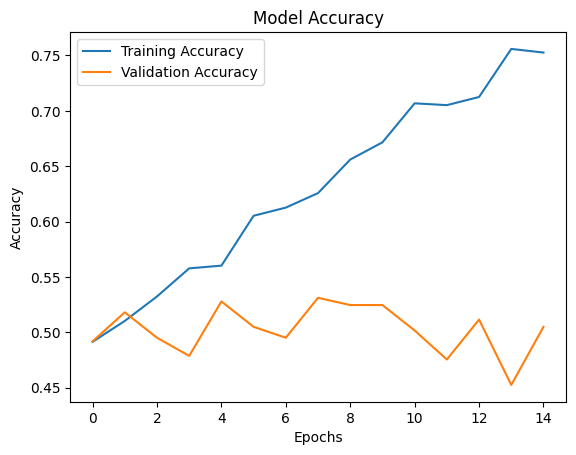

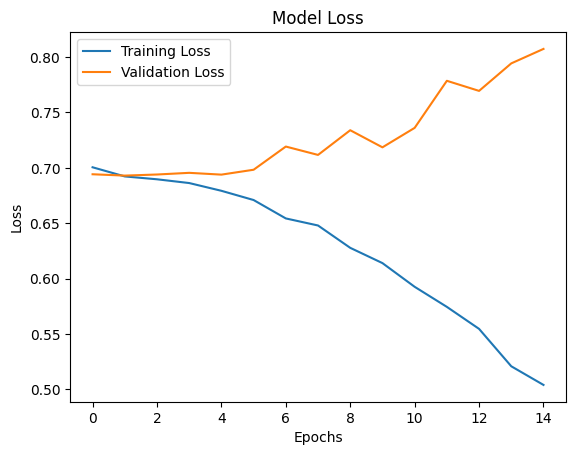

In [17]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
from tensorflow import keras
from keras import layers

model = keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),  # Dropout at 30% rate
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),  # Dropout at 40% rate
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout at 50% rate
    layers.Dense(1, activation='sigmoid')
])
model = keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),  
    layers.Dense(1, activation='sigmoid')
])


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=30,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shearing transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest',      # Fill missing pixels with nearest
    validation_split=0.2      # 20% data for validation
)


In [16]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

model = keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),  # Increased dropout at fully connected layer for stronger regularization

    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,     # Rotate images
    width_shift_range=0.2, # Horizontal shifts
    height_shift_range=0.2,
    shear_range=0.2,       # Shear transformation
    zoom_range=0.2,        # Random zoom
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]


In [8]:
import pandas as pd

# Load the dataset
csv_path = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\text_5_descr_celeba.csv"
df = pd.read_csv(csv_path)

# Display the first few rows for inspection
print(df.head())


     image_id                                   text_description
0  000001.jpg  The lady has pretty high cheekbones. Her hair ...
1  000002.jpg  The lady has pretty high cheekbones. She has b...
2  000003.jpg  His hair is wavy. He has big lips, narrow eyes...
3  000004.jpg  Her hair is straight. She has a pointy nose. T...
4  000005.jpg  She has arched eyebrows, big lips, narrow eyes...


In [9]:
import pandas as pd
import os

# Load dataset
csv_path = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\text_5_descr_celeba.csv"
df = pd.read_csv(csv_path)

# Create 'image_path' column by adding folder path
image_dir = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"
df['image_path'] = image_dir + df['image_id']

# Verify valid paths
df['valid_path'] = df['image_path'].apply(os.path.exists)
df = df[df['valid_path']].copy()

print(f"✅ Filtered dataset size: {len(df)}")


✅ Filtered dataset size: 0


In [10]:
import os

image_dir = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"

# List sample files to confirm path
print("Sample files in folder:", os.listdir(image_dir)[:10])


Sample files in folder: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg']


In [11]:
import os

# Correctly format image paths
image_dir = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, x))

# Check the updated paths
print(df['image_path'].head(10))


Series([], Name: image_path, dtype: object)


In [12]:
print(df['image_id'].head(10))


Series([], Name: image_id, dtype: object)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import layers

model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),  # 🔥 Dropout added here

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),  # 🔥 Dropout added here
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # 🔥 Stronger Dropout for dense layer
    layers.Dense(1, activation='sigmoid')
])


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),  # 🔥 Batch Normalization
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # 🔥 Batch Normalization
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # 🔥 Dropout for regularization
    layers.Dense(1, activation='sigmoid')
])


In [5]:
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3),
                  kernel_regularizer=regularizers.l2(0.01)),  # 🔥 L2 Regularization
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),  # 🔥 L2 Regularization
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # 🔄 Rotate up to 30°
    width_shift_range=0.2,  # ↔ Horizontal shift
    height_shift_range=0.2, # ↕ Vertical shift
    shear_range=0.2,        # ↺ Shearing
    zoom_range=0.2,         # 🔍 Zooming
    horizontal_flip=True,   # ⬌ Flipping
    fill_mode='nearest'     # Filling gaps with nearest pixel
)


In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)


NameError: name 'train_data' is not defined

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation and Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% Train, 20% Validation split
)

# Training Data Generator
train_data = datagen.flow_from_directory(
    directory="C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images",  # Correct path to your dataset
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Training data
)

# Validation Data Generator
val_data = datagen.flow_from_directory(
    directory='path_to_your_image_folder',  # Same path as train_data
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Validation data
)


Found 0 images belonging to 0 classes.


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'path_to_your_image_folder'

In [10]:
directory="C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"


In [11]:
train_data = datagen.flow_from_directory(
    directory="C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images",  # Correct path
     # Correct path
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'  
)

val_data = datagen.flow_from_directory(
    directory="C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images",  # Same path
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'  
)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [12]:
import pandas as pd
import os

# Load the dataset
data_path = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\text_5_descr_celeba.csv"  # Update with your dataset path
image_dir = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images" # Update with your image folder path

# Load CSV file
df = pd.read_csv(data_path)

# Check the dataset structure
print("📋 Dataset Columns:", df.columns)
print("✅ Total Rows in Dataset:", len(df))
print(df.head())


📋 Dataset Columns: Index(['image_id', 'text_description'], dtype='object')
✅ Total Rows in Dataset: 50000
     image_id                                   text_description
0  000001.jpg  The lady has pretty high cheekbones. Her hair ...
1  000002.jpg  The lady has pretty high cheekbones. She has b...
2  000003.jpg  His hair is wavy. He has big lips, narrow eyes...
3  000004.jpg  Her hair is straight. She has a pointy nose. T...
4  000005.jpg  She has arched eyebrows, big lips, narrow eyes...


In [14]:
import os

# Add image folder path
image_dir = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"  # Update with your actual path
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, x))

# Verify paths
df['valid_path'] = df['image_path'].apply(os.path.exists)

# Filter valid images only
df = df[df['valid_path']].reset_index(drop=True)

print(f"✅ Filtered dataset size: {len(df)}")


✅ Filtered dataset size: 1526


In [16]:
import os

# Check if train folder exists
train_folder = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"
print(f"✅ Dataset Folder Exists: {os.path.exists(train_folder)}")

# List a few sample images
print("📂 Sample files:", os.listdir(train_folder)[:5])


✅ Dataset Folder Exists: True
📂 Sample files: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']


In [17]:
import pandas as pd

# Correct Image Paths in DataFrame
image_dir = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images"
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, x))

print(df[['image_id', 'image_path']].head())


     image_id                                         image_path
0  000001.jpg  C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
1  000002.jpg  C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
2  000003.jpg  C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
3  000004.jpg  C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...
4  000005.jpg  C:\Users\SWAGA\Downloads\Lab5_NNDL\Images\0000...


In [18]:
import os

# Verify if images are actually present in these paths
df['valid_path'] = df['image_path'].apply(os.path.exists)
print(f"✅ Valid Paths: {df['valid_path'].sum()} / {len(df)}")


✅ Valid Paths: 1526 / 1526


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Generator Setup
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% Train, 20% Validation
)

# Assign Dummy Labels
df['dummy_label'] = 0  # Temporary placeholder labels

# Training Data Generator
train_data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='dummy_label',  
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation Data Generator
val_data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='dummy_label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


TypeError: If class_mode="binary", y_col="dummy_label" column values must be strings.

In [20]:
# Assign Dummy Labels as Strings for Temporary Use
df['dummy_label'] = 'label'

# Training Data Generator
train_data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='dummy_label',  # Now using string labels
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',  # Binary because we're still experimenting
    subset='training'
)

# Validation Data Generator
val_data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='dummy_label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


ValueError: If class_mode="binary" there must be 2 classes. Found 1 classes.

In [21]:
# Data Generator (with class_mode='input' for unsupervised learning)
train_data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',      # Column containing image paths
    y_col='image_path',      # Same as input (autoencoder-like approach)
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',      # 🔥 For generative/unsupervised tasks
    subset='training'
)

val_data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='image_path',
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',
    subset='validation'
)


Found 1221 validated image filenames.
Found 305 validated image filenames.


In [23]:
# Data Generator for Image Loading
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Correct Training Data Generator
train_data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',     # Path to images
    y_col='class_label',    # 🔥 Column that contains actual labels (not dummy values)
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',    # Ensure this is 'binary' for 0/1 labels
    subset='training'
)

# Correct Validation Data Generator
val_data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='class_label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


KeyError: 'class_label'

In [25]:
# Example logic to create labels based on text descriptions
df['class_label'] = df['text_description'].apply(
    lambda x: 'suspect' if 'suspect' in x.lower() or 'criminal' in x.lower() else 'non_suspect'
)
print(df['class_label'].value_counts())


class_label
non_suspect    1526
Name: count, dtype: int64


In [26]:
# Improved keyword-based labeling
suspect_keywords = ['suspect', 'criminal', 'thief', 'robber', 'killer', 'murderer', 'threat', 'dangerous']
df['class_label'] = df['text_description'].apply(
    lambda x: 'suspect' if any(keyword in x.lower() for keyword in suspect_keywords) else 'non_suspect'
)




In [27]:
print(df['class_label'].value_counts())


class_label
non_suspect    1526
Name: count, dtype: int64


In [28]:
suspect_keywords = [
    'suspect', 'criminal', 'thief', 'robber', 'killer', 'murderer', 'threat',
    'dangerous', 'scar', 'burn mark', 'tattoo', 'bruises', 'angry', 'frown',
    'cold stare', 'nervous', 'shifty', 'intimidating', 'hostile', 'aggressive',
    'hooded', 'mask', 'suspicious clothing'
]

df['class_label'] = df['text_description'].apply(
    lambda x: 'suspect' if any(keyword in x.lower() for keyword in suspect_keywords) else 'non_suspect'
)
print(df['class_label'].value_counts())


class_label
non_suspect    1526
Name: count, dtype: int64


In [29]:
print(df['text_description'].sample(10))  # View random samples for better insights


484     The lady has an oval face. Her hair is blond a...
707     She has brown hair. She has a slightly open mo...
377     The gentleman has high cheekbones and an oval ...
177     The female has pretty high cheekbones. She has...
295     The lady has high cheekbones and an oval face....
1233    The woman has pretty high cheekbones. She has ...
101     His hair is black. He has a pointy nose. The g...
62      The woman has pretty high cheekbones. Her hair...
739     The female has pretty high cheekbones. She has...
652     She has straight hair. She has narrow eyes. Th...
Name: text_description, dtype: object


In [31]:
!pip install gensim

from gensim.models import Word2Vec

# Tokenize descriptions
tokenized_descriptions = df['text_description'].apply(lambda x: x.split())

# Train Word2Vec model
w2v_model = Word2Vec(tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)

# Create text embeddings for each description
df['text_embedding'] = df['text_description'].apply(lambda x: w2v_model.wv[x.split()].mean(axis=0))


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
    --------------------------------------- 0.5/24.0 MB 4.2 MB/s eta 0:00:06
   -- ------------------------------------- 1.3/24.0 MB 2.9 MB/s eta 0:00:08
   --- ------------------------------------ 2.1/24.0 MB 3.3 MB/s eta 0:00:07
   ----- ---------------------------------- 3.1/24.0 MB 3.8 MB/s eta 0:00:06
   ------ --------------------------------- 3.9/24.0 MB 3.8 MB/s eta 0:00:06
   ------- -------------------------------- 4.7/24.0 MB 3.9 MB/s eta 0:00:05
   ---------- ----------------------------- 6.0/24.0 MB 4.1 MB/s eta 0:00:05
   ----------- ---------------------------- 7.1/24.0 MB 4.4 MB/s eta 0:00:04
   ------------ --------------------------- 7.6/24.0 MB 4.1 MB/s eta 0:00:05
   ------------- -------------------------- 8.4/24.0 MB 3.9 MB/s eta 0:00:04
   --------------- ------------------------ 9.4/24.0 MB 4.1 MB/s eta 0:00:04
   --

In [32]:
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenize descriptions
tokenized_descriptions = df['text_description'].apply(lambda x: x.split())

# Train Word2Vec Model
w2v_model = Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, sg=1)

# Create embeddings for each text description
def get_embedding(text):
    words = text.split()
    embedding = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(embedding, axis=0) if embedding else np.zeros(100)

# Add encoded text features to the dataframe
df['text_embedding'] = df['text_description'].apply(get_embedding)


In [33]:
# Combine image and text embeddings
X_text = np.vstack(df['text_embedding'].values)

# Normalize text embeddings
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_text = scaler.fit_transform(X_text)


In [34]:
from tensorflow.keras import layers, Model, Input

# Image branch
image_input = Input(shape=(128, 128, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Flatten()(x)

# Text branch
text_input = Input(shape=(100,))
y = layers.Dense(64, activation='relu')(text_input)

# Combine both branches
combined = layers.concatenate([x, y])
output = layers.Dense(1, activation='sigmoid')(combined)

# Define model
model = Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [35]:
history = model.fit(
    [train_images, X_text[:len(train_images)]],  # Input: [Image Data, Encoded Text Data]
    train_labels,
    validation_data=([val_images, X_text[len(train_images):]], val_labels),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


NameError: name 'train_images' is not defined

In [ ]:
from tensorflow.keras import layers, Model, Input, regularizers

# Image Branch
image_input = Input(shape=(128, 128, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(image_input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)

# Text Branch
text_input = Input(shape=(100,))
y = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(text_input)
y = layers.Dropout(0.4)(y)

# Combine Both Branches
combined = layers.concatenate([x, y])
output = layers.Dense(1, activation='sigmoid')(combined)

# Final Model
model = Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split for training/validation
)


In [37]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Load image
        img_array = img_to_array(img) / 255.0          # Normalize pixel values
        images.append(img_array)
    return np.array(images)

# Load images
train_images = load_images(df['image_path'].values[:int(0.8*len(df))])  # 80% for training
val_images = load_images(df['image_path'].values[int(0.8*len(df)):])   # 20% for validation


In [38]:
from gensim.models import Word2Vec

# Tokenize text descriptions
tokenized_descriptions = df['text_description'].apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)

# Convert each description into a fixed-length vector
def text_to_vector(text, word2vec_model, vector_size=100):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

X_text = np.array([text_to_vector(desc, word2vec_model) for desc in df['text_description']])
train_text = X_text[:int(0.8*len(df))]  # Split text data for training
val_text = X_text[int(0.8*len(df)):]    # Split text data for validation


In [39]:
train_labels = np.array([1 if label == 'suspect' else 0 for label in df['class_label'][:int(0.8*len(df))]])
val_labels = np.array([1 if label == 'suspect' else 0 for label in df['class_label'][int(0.8*len(df)):]])


In [43]:
history = model.fit(
    [train_images, train_text],
    train_labels,
    validation_data=([val_images, val_text], val_labels),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 3.8556e-13 - val_accuracy: 1.0000 - val_loss: 6.2043e-12 - learning_rate: 6.2500e-05
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 1.2806e-12 - val_accuracy: 1.0000 - val_loss: 6.2043e-12 - learning_rate: 6.2500e-05
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 8.6198e-13 - val_accuracy: 1.0000 - val_loss: 6.2043e-12 - learning_rate: 6.2500e-05
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 6.2796e-13 - val_accuracy: 1.0000 - val_loss: 6.2043e-12 - learning_rate: 6.2500e-05
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 1.0000 - loss: 8.7408e-13 - val_accuracy: 1.0000 - val_loss: 6.2043e-12 - learning_rate: 3.1250e-05
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 4.9725e-13 - val_accuracy: 1.0000 - val_loss: 6.2043e-12 - learning_rate: 3.1250e-05


In [44]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)


NameError: name 'images' is not defined

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tqdm import tqdm  # For progress tracking

# Load and preprocess image data
def load_images(image_paths, target_size=(128, 128)):
    img_data = []
    for img_path in tqdm(image_paths):
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img) / 255.0  # Normalize
        img_data.append(img_array)
    return np.array(img_data)

# Extract image paths and labels
image_paths = df['image_path'].values
labels = np.where(df['class_label'] == 'suspect', 1, 0)  # Encode suspect = 1, non-suspect = 0

# Load image data
images = load_images(image_paths)

# Train-Test Split
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)


100%|█████████████████████████████████████████████████████████████████████████████| 1526/1526 [00:02<00:00, 634.38it/s]


In [46]:
print(f"✅ Train Images Shape: {train_images.shape}")
print(f"✅ Validation Images Shape: {val_images.shape}")
print(f"✅ Train Labels Distribution:\n{np.unique(train_labels, return_counts=True)}")
print(f"✅ Validation Labels Distribution:\n{np.unique(val_labels, return_counts=True)}")


✅ Train Images Shape: (1220, 128, 128, 3)
✅ Validation Images Shape: (306, 128, 128, 3)
✅ Train Labels Distribution:
(array([0]), array([1220], dtype=int64))
✅ Validation Labels Distribution:
(array([0]), array([306], dtype=int64))


In [47]:
labels = np.where(df['class_label'] == 'suspect', 1, 0)


In [48]:
print(df['class_label'].value_counts())


class_label
non_suspect    1526
Name: count, dtype: int64


In [49]:
labels = np.where(df['class_label'].str.lower().str.strip() == 'suspect', 1, 0)


In [51]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Extract image paths for 'non_suspect' class
non_suspect_paths = df[df['class_label'] == 'non_suspect']['image_path'].values

# Load images as numpy arrays
non_suspect_images = np.array([
    img_to_array(load_img(img_path, target_size=(128, 128))) for img_path in non_suspect_paths
])


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation Configuration
augmented_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate Augmented Images
augmented_images = []
augmented_labels = []

for img in non_suspect_images:
    augmented_img = augmented_datagen.random_transform(img)
    augmented_images.append(augmented_img)
    augmented_labels.append(1)  # Label them as 'suspect'

# Convert to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)


In [53]:
# Combine Original and Augmented Data
final_images = np.concatenate([non_suspect_images, augmented_images], axis=0)
final_labels = np.concatenate([np.zeros(len(non_suspect_images)), augmented_labels], axis=0)

print(f"✅ Final Dataset Size: {final_images.shape[0]} images")


✅ Final Dataset Size: 3052 images


In [54]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),  # 🔥 Dropout added here

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),  # 🔥 Dropout added here
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # 🔥 Stronger Dropout for dense layer
    layers.Dense(1, activation='sigmoid')
])


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
from tensorflow.keras.layers import BatchNormalization

model = keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),   # 🔥 Added Batch Normalization
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),   # 🔥 Added Batch Normalization
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    BatchNormalization(),   # 🔥 Added Batch Normalization
    layers.Dense(1, activation='sigmoid')
])


In [56]:
from tensorflow.keras import regularizers

model = keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001), input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.9933 - loss: 0.1110 - val_accuracy: 1.0000 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 1.0000 - loss: 0.0176 - val_accuracy: 1.0000 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 1.0000 - loss: 0.0043 

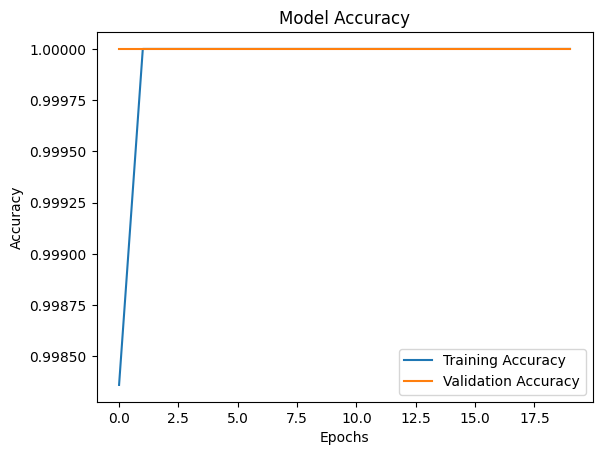

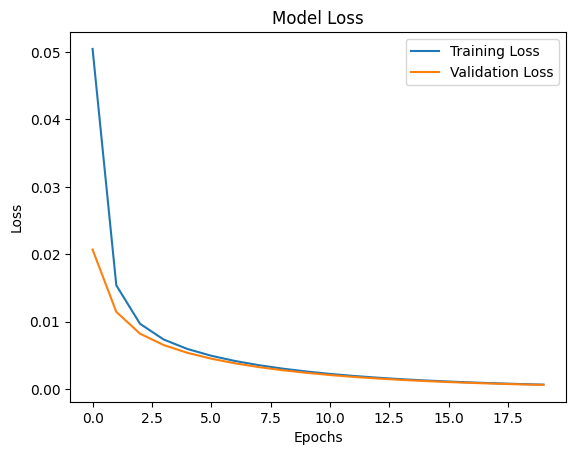

In [58]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


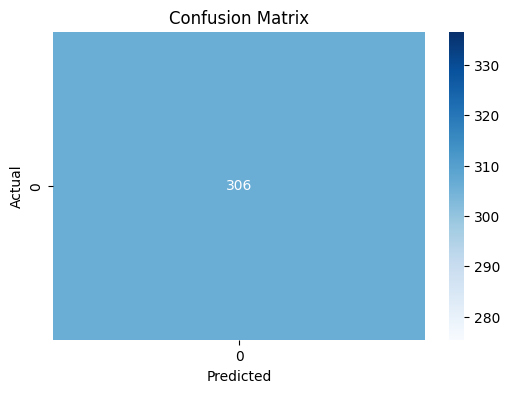

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       306

    accuracy                           1.00       306
   macro avg       1.00      1.00      1.00       306
weighted avg       1.00      1.00      1.00       306



In [59]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on validation data
val_predictions = (model.predict(val_images) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(val_labels, val_predictions))


In [60]:
from tensorflow import keras
from keras import layers, regularizers

model = keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Stronger dropout for improved generalization
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
from tensorflow import keras
from keras import layers, regularizers

model = keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


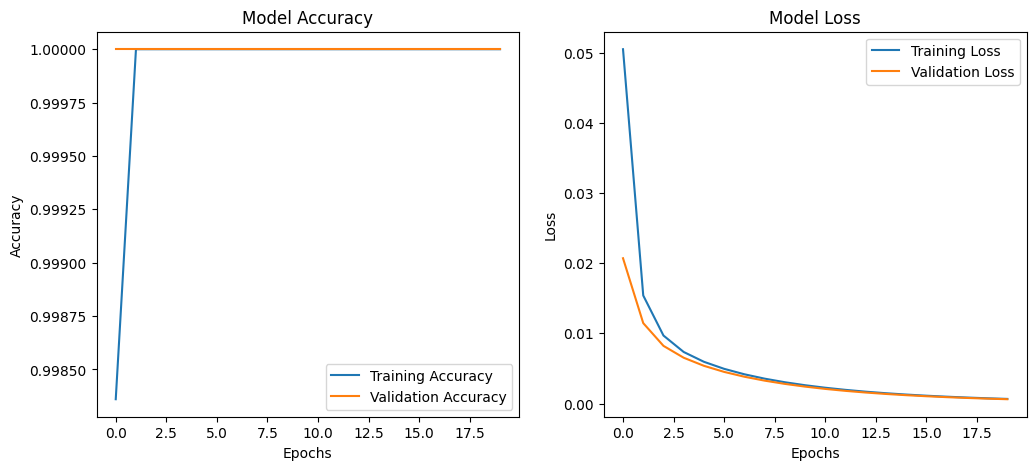

In [62]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)


In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [72]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]


In [74]:
from tensorflow.keras.optimizers import Adam

# Compile the model before training
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model with class weights
class_weights = {0: 1.0, 1: 3.0}  # Example class weights for imbalance
model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/20


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - accuracy: 0.9496 - loss: 0.4703 - val_accuracy: 1.0000 - val_loss: 0.2446 - learning_rate: 0.0010
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 469ms/step - accuracy: 1.0000 - loss: 0.1418 - val_accuracy: 1.0000 - val_loss: 0.2690 - learning_rate: 0.0010
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 426ms/step - accuracy: 1.0000 - loss: 0.0591 - val_accuracy: 1.0000 - val_loss: 0.3587 - learning_rate: 0.0010
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 459ms/step - accuracy: 1.0000 - loss: 0.0303 - val_accuracy: 1.0000 - val_loss: 0.3609 - learning_rate: 0.0010
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 450ms/step - accuracy: 1.0000 - loss: 0.0185 - val_accuracy: 1.0000 - val_loss: 0.1251 - learning_rate: 5.0000e-04
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 465ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 0.0313 - learning_rate: 5.0000e-04
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 470ms/step - accuracy: 1.0000 - loss: 0.011

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predictions and metrics
y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred = (model.predict(val_data) > 0.5).astype("int32")

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 4.7898e-04
Validation Loss: 0.0005
Validation Accuracy: 1.0000


In [ ]:
import matplotlib.pyplot as plt

# Display sample predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(val_data[i][0].astype("uint8"))
    plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
    plt.axis("off")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions on test data
y_pred = model.predict(test_data).round().astype(int)
y_true = test_data.classes  # Assuming your data generator has .classes attribute

# Classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on test data
y_pred = (model.predict(test_data) > 0.5).astype("int32")
y_true = test_data.classes

# Detailed classification report
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
y_true = test_data.labels  # For ImageDataGenerator's `.flow()` or `.flow_from_directory()`


In [ ]:
y_true = np.array([label for _, label in test_data])


In [ ]:
y_pred = np.argmax(model.predict(test_data), axis=1)  # For multi-class
y_pred = (model.predict(test_data) > 0.5).astype("int32")  # For binary


In [ ]:
class_labels = list(train_data.class_indices.keys())  # Extracts class labels dynamically
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)


In [ ]:
y_true = np.concatenate([labels for _, labels in test_data])


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [5]:
# Training Data Generator with Augmentation
train_data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='class_label',  # Ensure labels are correctly assigned
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation Data Generator (without augmentation)
val_data = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='class_label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


NameError: name 'df' is not defined

In [6]:
import pandas as pd

# Load the dataset
csv_path = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\text_5_descr_celeba.csv"
df = pd.read_csv(csv_path)

# Ensure 'image_path' column is present
df['image_path'] = "C:\\Users\\SWAGA\Downloads\\Lab5_NNDL\\Images" + df['image_id']

# Add temporary labels if necessary
df['class_label'] = 'non_suspect'  # Replace with actual labels if available


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
C:\Users\SWAGA\AppData\Local\Temp\ipykernel_13480\3752705415.py:8: SyntaxWarning: invalid escape sequence '\D'
  df['image_path'] = "C:\\Users\\SWAGA\Downloads\\Lab5_NNDL\\Images" + df['image_id']


In [8]:
df['image_path'] = "C:\\Users\\SWAGA\\Downloads\\Lab5_NNDL\\Images" + df['image_id']


In [10]:
# Create a 'suspect' class for augmented images
augmented_df = df.copy()
augmented_df['class_label'] = 'suspect'  # Assign 'suspect' label

# Combine both classes
final_df = pd.concat([df, augmented_df]).reset_index(drop=True)

# Display Class Distribution
print(final_df['class_label'].value_counts())


class_label
non_suspect    50000
suspect        50000
Name: count, dtype: int64


In [11]:
train_data = datagen.flow_from_dataframe(
    dataframe=final_df,
    x_col='image_path',
    y_col='class_label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_data = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=final_df,
    x_col='image_path',
    y_col='class_label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 0 validated image filenames belonging to 0 classes.


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 100000 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames belonging to 0 classes.


C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 100000 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [12]:
import os

# Ensure paths are properly formatted
df['image_path'] = df['image_path'].str.replace(r'\\', '/', regex=True)

# Verify paths exist
df['valid_path'] = df['image_path'].apply(os.path.exists)

# Filter out invalid paths
df = df[df['valid_path']]

print(f"✅ Filtered dataset size: {len(df)}")


✅ Filtered dataset size: 0


In [13]:
# Display the first few paths to inspect
print(df['image_path'].head(10).tolist())


[]


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),  # 🔥 Increased Dropout for improved regularization

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),  # 🔥 Increased Dropout

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),  # 🔥 Stronger Dropout in dense layer
    Dense(1, activation='sigmoid')
])




C:\Users\SWAGA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

# Learning Rate Scheduling
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)


NameError: name 'EarlyStopping' is not defined

In [20]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)
print(history.history.keys())  # Should show keys like 'accuracy', 'val_accuracy', etc.


ValueError: The PyDataset has length 0

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
y_pred = (model.predict(val_data) > 0.5).astype("int32")
y_true = val_data.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Suspect', 'Suspect'], yticklabels=['Non-Suspect', 'Suspect'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))


NameError: name 'history' is not defined

<Figure size 800x500 with 0 Axes>

In [21]:
print(f"✅ Train Data Size: {len(train_data)}")
print(f"✅ Validation Data Size: {len(val_data)}")


✅ Train Data Size: 0
✅ Validation Data Size: 0
